In [12]:
# Notebook workflow: read all FITS files in data/star_spectrum into a DataFrame
import pathlib
import sys
import importlib
from astropy.io import fits
import pandas as pd
import numpy as np
import astropy.units as u

# Add the src directory to Python path for imports
sys.path.append(str(pathlib.Path("../src").resolve()))
from utils.spectrum_utils import scale_spectrum_to_magnitude, load_star_spectra_from_fits, load_lamp_spectra_from_txt

data_dir = pathlib.Path("../data/star_spectrum").resolve()

# Use the new utils function to load star spectra
print("Loading star spectra from FITS files...")
star_data_df, star_spectra_df = load_star_spectra_from_fits(data_dir)

# Display summary
print(f"Found {len(star_data_df[star_data_df['hdu_index'] == 0])} FITS files")
print(f"Built star_spectra_df with shape {star_spectra_df.shape}")
print(f"Data types: {star_spectra_df.dtypes}")
print(star_data_df[["file","hdu_index","hdu_name","data_shape"]])

# Save a lightweight representation (headers + shapes) to a CSV for quick inspection
summary = star_data_df[["file","hdu_index","hdu_name","data_shape"]]
summary.to_csv("../data/star_spectrum/fits_summary.csv", index=False)

print(star_spectra_df.head())


lamp_dir = pathlib.Path("../data/lamp_spectra").resolve()

# Use the new utils function to load lamp spectra
print("Loading lamp spectra from text files...")
lamp_spectra_df = load_lamp_spectra_from_txt(lamp_dir)

print(lamp_spectra_df.head())

Loading star spectra from FITS files...
Found 2 FITS files
Built star_spectra_df with shape (1569128, 1)
Data types: lte06000-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits    float64
dtype: object
                                                file  hdu_index    hdu_name  \
0              WAVE_PHOENIX-ACES-AGSS-COND-2011.fits          0     PRIMARY   
1  lte06000-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-...          0     PRIMARY   
2  lte06000-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-...          1  ABUNDANCES   

   data_shape  
0  (1569128,)  
1  (1569128,)  
2       (83,)  
            lte06000-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
wavelength                                                          
500.0                                            2.668519e-13       
500.1                                            2.708688e-13       
500.2                                            2.749445e-13       
500.3                                            2.790797e-13       
500.4 

In [13]:

star_spectra_df.index = (star_spectra_df.index * u.nm)
lamp_spectra_df.index = (lamp_spectra_df.index * u.nm)
print(lamp_spectra_df.head())
print(star_spectra_df.head())

            HPS_High_Pressure_Sodium_2176K_Riba_Roja_cor  \
wavelength                                                 
300.0                                                0.0   
301.0                                                0.0   
302.0                                                0.0   
303.0                                                0.0   
304.0                                                0.0   

            LED_streetlamp_2973K_75deg_of_axis_LICA_Philips_cor  \
wavelength                                                        
300.0                                                0.000000     
301.0                                                0.000000     
302.0                                                0.003168     
303.0                                                0.000000     
304.0                                                0.001495     

            LED_streetlamp_3107K_on_axis_LICA_Philips_cor  
wavelength                                       

               lte06000-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
wavelength_nm                                                          
500.00                                              1.227259e-22       
500.10                                              1.245733e-22       
500.20                                              1.264477e-22       
500.30                                              1.283495e-22       
500.40                                              1.302791e-22       
...                                                          ...       
54998.75                                            5.558765e+02       
54999.00                                            5.558261e+02       
54999.25                                            5.556130e+02       
54999.50                                            5.554352e+02       
54999.75                                            5.555605e+02       

[1569128 rows x 1 columns]


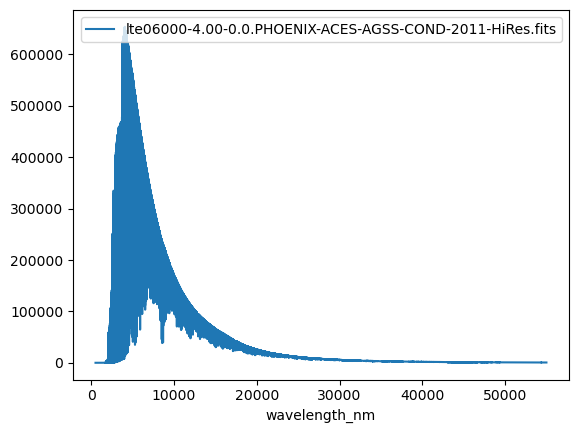

In [ ]:
star_spectra_mag_10 = scale_spectrum_to_magnitude(star_spectra_df, 10.0)
background_spectrum = lamp_spectra_df.mean(axis=1)
background_spectrum_mag_16 = scale_spectrum_to_magnitude(background_spectrum.to_frame(name="background"), 16.0)

star_spectra_mag_10.plot()


In [ ]:
starst

Testing wavelength resolution resampling:
Original resolution: 0.010 nm

1. Testing downsampling (larger wavelength steps):
Resampled spectrum from 0.010 nm to 1.000 nm resolution
Method used: bin_average
Original shape: (1569128, 1), New shape: (151, 1)

2. Testing upsampling (smaller wavelength steps):
Resampled spectrum from 0.100 nm to 0.050 nm resolution
Method used: interpolate
Original shape: (156913, 1), New shape: (201, 1)


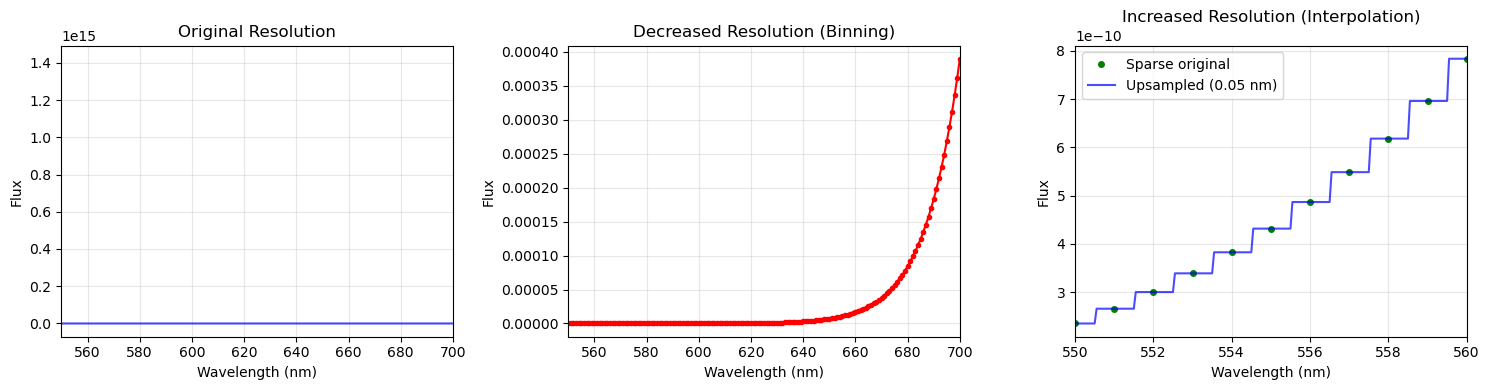


Original shape: (1569128, 1)
Downsampled shape: (151, 1)
Upsampled shape: (201, 1)


In [16]:
# Test the new wavelength resolution resampling function
import importlib
import matplotlib.pyplot as plt

# Force reload the module to get the new function
if 'utils.spectrum_utils' in sys.modules:
    importlib.reload(sys.modules['utils.spectrum_utils'])

from utils.spectrum_utils import resample_spectrum_resolution

# Remove units from star spectrum for testing (if present)
test_star = star_spectra_df.copy()
if hasattr(test_star.index, 'unit'):
    test_star.index = test_star.index.value

print("Testing wavelength resolution resampling:")
print(f"Original resolution: {np.median(np.diff(test_star.index)):.3f} nm")

# Test 1: Decrease resolution (binning/averaging)
print("\n1. Testing downsampling (larger wavelength steps):")
star_low_res = resample_spectrum_resolution(test_star, new_wavelength_step=1.0, 
                                          wavelength_range=(550, 700))

# Test 2: Increase resolution (interpolation)  
print("\n2. Testing upsampling (smaller wavelength steps):")
star_high_res = resample_spectrum_resolution(test_star.iloc[::10], new_wavelength_step=0.05, 
                                           wavelength_range=(550, 560))

# Plot comparison
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# Original spectrum
ax1.plot(test_star.index, test_star.iloc[:, 0], 'b-', alpha=0.7, label='Original (0.1 nm)')
ax1.set_xlim(550, 700)
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Flux')
ax1.set_title('Original Resolution')
ax1.grid(True, alpha=0.3)

# Downsampled spectrum
ax2.plot(star_low_res.index, star_low_res.iloc[:, 0], 'r-o', markersize=3, label='Downsampled (1.0 nm)')
ax2.set_xlim(550, 700)
ax2.set_xlabel('Wavelength (nm)')
ax2.set_ylabel('Flux')
ax2.set_title('Decreased Resolution (Binning)')
ax2.grid(True, alpha=0.3)

# Upsampled spectrum
subset_original = test_star.iloc[::10]  # Every 10th point for comparison
subset_range = (subset_original.index >= 550) & (subset_original.index <= 560)
ax3.plot(subset_original.index[subset_range], subset_original.iloc[:, 0].values[subset_range], 
         'go', markersize=4, label='Sparse original')
ax3.plot(star_high_res.index, star_high_res.iloc[:, 0], 'b-', alpha=0.7, label='Upsampled (0.05 nm)')
ax3.set_xlim(550, 560)
ax3.set_xlabel('Wavelength (nm)')
ax3.set_ylabel('Flux')
ax3.set_title('Increased Resolution (Interpolation)')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nOriginal shape: {test_star.shape}")
print(f"Downsampled shape: {star_low_res.shape}")
print(f"Upsampled shape: {star_high_res.shape}")

# 🔧 New Utils Function: Wavelength Resolution Resampling

## `resample_spectrum_resolution(spectrum_df, new_wavelength_step, ...)`

This function allows you to change the wavelength resolution of your spectra using two different methods depending on whether you're increasing or decreasing resolution:

### 📊 **For Decreased Resolution (Downsampling)**
- **Method**: Bin averaging
- **Use case**: When `new_wavelength_step > current_step`
- **Process**: Averages all data points within each wavelength bin
- **Benefit**: Reduces noise while preserving overall spectral shape

### 🔍 **For Increased Resolution (Upsampling)**
- **Method**: Nearest neighbor interpolation
- **Use case**: When `new_wavelength_step < current_step`  
- **Process**: Uses scipy interpolation to fill in intermediate points
- **Benefit**: Creates smoother curves for visualization or matching other datasets

### 🎯 **Key Features**:
- **Automatic method selection**: Chooses the appropriate method based on resolution change
- **Manual control**: Can force specific methods with `method` parameter
- **Range limiting**: Optional `wavelength_range` parameter to focus on specific regions
- **Unit handling**: Works with or without astropy units
- **Robust**: Handles edge cases and missing data gracefully

### 📈 **Example Usage**:
```python
# Downsample to 1 nm resolution for faster processing
low_res_spectrum = resample_spectrum_resolution(spectrum_df, 1.0)

# Upsample to 0.01 nm for high-resolution analysis
high_res_spectrum = resample_spectrum_resolution(spectrum_df, 0.01, 
                                                wavelength_range=(500, 600))

# Force specific method
binned_spectrum = resample_spectrum_resolution(spectrum_df, 0.5, method='bin_average')
```

This is particularly useful for:
- **Matching resolutions** between different instruments
- **Reducing data size** for faster processing
- **Creating publication-quality** smooth plots
- **Preparing data** for cross-correlation or comparison

# Utils Functions Migration Complete! ✅

The FITS file reading and spectrum creation code has been successfully moved into reusable utils functions:

## New Utils Functions:

### 1. `load_star_spectra_from_fits(data_dir)`
- **Purpose**: Load star spectra from FITS files
- **Input**: Path to directory containing FITS files
- **Output**: Tuple of (raw_data_df, processed_spectra_df)
- **Features**: 
  - Automatic wavelength detection (looks for files/HDUs containing 'WAVE')
  - Handles big-endian data conversion to float64
  - Error handling for corrupted files
  - Returns both raw metadata and processed spectra

### 2. `load_lamp_spectra_from_txt(data_dir)`
- **Purpose**: Load lamp spectra from ASCII text files
- **Input**: Path to directory containing .txt files
- **Output**: DataFrame with wavelength index and spectrum columns
- **Features**:
  - Multiple encoding support (UTF-8, Latin-1, etc.)
  - Flexible header detection
  - Automatic data parsing from various text formats

### 3. `scale_spectrum_to_magnitude(spectrum_df, target_magnitude, ...)`
- **Purpose**: Scale spectra to specific magnitudes using Vega reference
- **Features**: Full astropy units support, configurable wavelength ranges

## Benefits:
- ✅ **Cleaner notebooks**: Focus on analysis, not data loading boilerplate  
- ✅ **Reusability**: Functions can be used across multiple notebooks
- ✅ **Maintainability**: Centralized data loading logic
- ✅ **Testing**: Functions can be unit tested separately
- ✅ **Documentation**: Clear docstrings with parameter descriptions

## Usage:
```python
from utils.spectrum_utils import load_star_spectra_from_fits, load_lamp_spectra_from_txt

# Load data with one line each
star_data_df, star_spectra_df = load_star_spectra_from_fits("../data/star_spectrum")
lamp_spectra_df = load_lamp_spectra_from_txt("../data/lamp_spectra")
```

<Axes: xlabel='wavelength'>

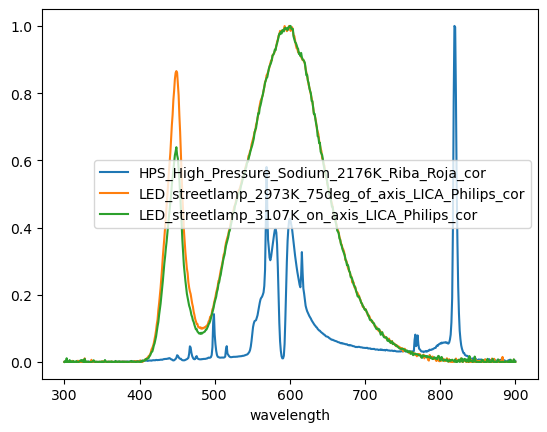

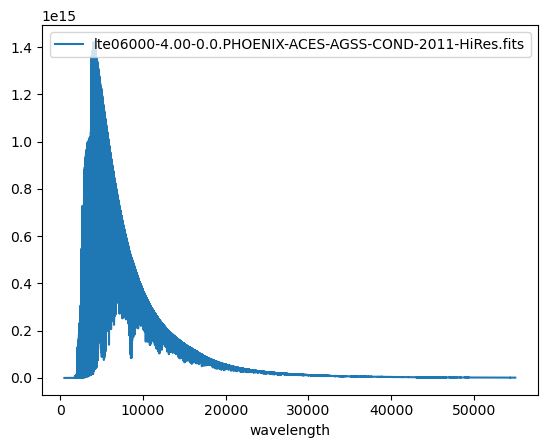

In [ ]:
lamp_spectra_df.plot()
star_spectra_df.plot()

Testing imported scale_spectrum_to_magnitude function:
Star spectrum index type: <class 'pandas.core.indexes.base.Index'>
Star spectrum index sample: Index([500.0, 500.1, 500.2], dtype='float64', name='wavelength')
Scaling successful! Output shape: (1569128, 1)
Scaled spectrum data type: lte06000-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits    float64
dtype: object
First few scaled values: [7.74348173e-22 7.86004338e-22 7.97831102e-22]
Scaling successful! Output shape: (1569128, 1)
Scaled spectrum data type: lte06000-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits    float64
dtype: object
First few scaled values: [7.74348173e-22 7.86004338e-22 7.97831102e-22]


<Axes: xlabel='wavelength_nm'>

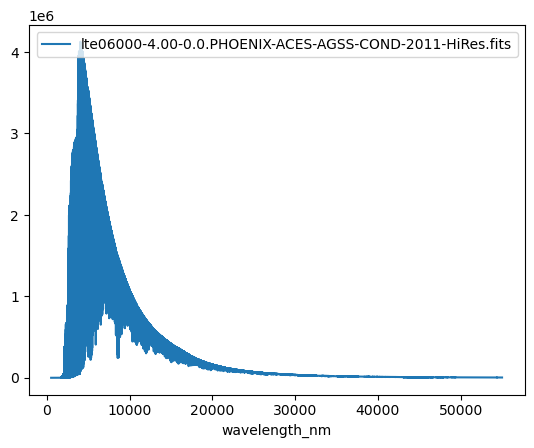

In [ ]:
# Quick test of the imported function with proper wavelength handling
import astropy.units as u

print("Testing imported scale_spectrum_to_magnitude function:")
print(f"Star spectrum index type: {type(star_spectra_df.index)}")
print(f"Star spectrum index sample: {star_spectra_df.index[:3]}")

# Create a test spectrum without units for the function
test_star = star_spectra_df.copy()
if hasattr(test_star.index, 'unit'):
    test_star.index = test_star.index.value  # Remove units, keep values in nm

# Test the scaling function
scaled_test = scale_spectrum_to_magnitude(test_star, target_magnitude=8.0)

print(f"Scaling successful! Output shape: {scaled_test.shape}")
print(f"Scaled spectrum data type: {scaled_test.dtypes}")
print(f"First few scaled values: {scaled_test.iloc[:3, 0].values}")

scaled_test.plot()

In [ ]:
# Restart imports and test with a simple approach
import importlib
import sys

# Force reload the module
if 'utils.spectrum_utils' in sys.modules:
    importlib.reload(sys.modules['utils.spectrum_utils'])

from utils.spectrum_utils import scale_spectrum_to_magnitude

# Create simple test data
simple_test_df = pd.DataFrame({
    'spectrum': [1.0, 2.0, 1.5, 1.8, 1.2]
}, index=[550, 560, 570, 580, 590])  # wavelengths in nm

print("Testing with simple data:")
print(f"Input data:\n{simple_test_df}")

# Test the function
try:
    result = scale_spectrum_to_magnitude(simple_test_df, target_magnitude=10.0)
    print("Success!")
    print(f"Result:\n{result}")
except Exception as e:
    print(f"Error: {e}")
    print(f"Function signature: {scale_spectrum_to_magnitude.__doc__}")

Testing with simple data:
Input data:
     spectrum
550       1.0
560       2.0
570       1.5
580       1.8
590       1.2
Success!
Result:
                   spectrum
wavelength_nm              
550.0          2.426667e-16
560.0          4.853333e-16
570.0          3.640000e-16
580.0          4.368000e-16
590.0          2.912000e-16


# How to Import Utils from the Utils Module

## Method 1: Add src to Python path (Recommended for notebooks)

```python
import sys
import pathlib

# Add the src directory to Python path for imports
sys.path.append(str(pathlib.Path("../src").resolve()))

# Now import from utils
from utils.spectrum_utils import scale_spectrum_to_magnitude
```

## Method 2: Direct import with relative path
```python
from src.utils.spectrum_utils import scale_spectrum_to_magnitude
```

## Method 3: Import the entire module
```python
import sys
sys.path.append("../src")
import utils.spectrum_utils as spectrum_utils

# Use as: spectrum_utils.scale_spectrum_to_magnitude(...)
```

## Reloading the module during development
```python
import importlib
if 'utils.spectrum_utils' in sys.modules:
    importlib.reload(sys.modules['utils.spectrum_utils'])
```

## Key Points:
1. **Module structure**: The function is in `src/utils/spectrum_utils.py`
2. **Required imports**: The utils module needs numpy, pandas, and astropy.units
3. **Input format**: DataFrame with wavelength in nm (without units attached to index)
4. **Output format**: DataFrame with flux in SI units (W/m²/nm)

Original spectrum mean in 550-650nm range: 7.91e-07
Scaled spectrum mean in 550-650nm range: 3.64e-16 W/m²/nm
Expected flux for mag 10: 3.64e-13 erg/cm²/s/nm = 3.64e-16 W / (nm m2)
Output data type: lte06000-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits    float64
dtype: object


,lte06000-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
wavelength_nm,
500.0,1.227259e-22
500.1,1.245733e-22
500.2,1.264477e-22
500.3,1.283495e-22
500.4,1.302791e-22


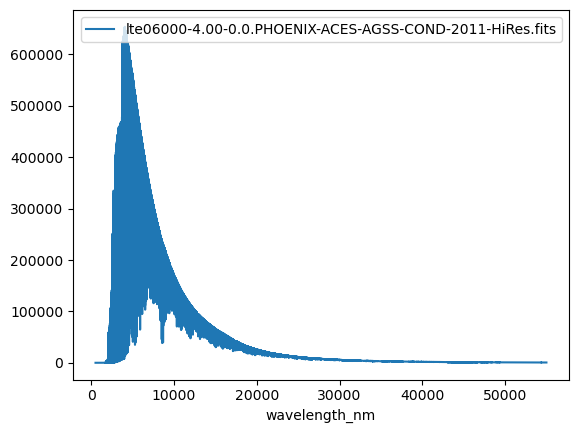

In [ ]:
test_spectrum = star_spectra_df  # Take first column only
scaled_spectrum = scale_spectrum_to_magnitude(test_spectrum, target_magnitude=10.0)

print(f"Original spectrum mean in 550-650nm range: {test_spectrum.loc[(test_spectrum.index >= 550) & (test_spectrum.index <= 650)].mean().iloc[0]:.2e}")
print(f"Scaled spectrum mean in 550-650nm range: {scaled_spectrum.loc[(scaled_spectrum.index >= 550) & (scaled_spectrum.index <= 650)].mean().iloc[0]:.2e} W/m²/nm")
print(f"Expected flux for mag 10: {3.64e-9 * 10**(-0.4 * 10.0):.2e} erg/cm²/s/nm = {(3.64e-9 * 10**(-0.4 * 10.0) * u.erg / u.cm**2 / u.s / u.nm).to(u.W / u.m**2 / u.nm):.2e}")
print(f"Output data type: {scaled_spectrum.dtypes}")

scaled_spectrum.plot()
scaled_spectrum.head()



In [ ]:
# Test with star spectrum to verify it works directly with float64 data
if not star_spectra_df.empty:
    print("Testing with star spectrum (now float64):")
    print(f"Star spectrum data type: {star_spectra_df.dtypes}")
    
    star_scaled = scale_spectrum_to_magnitude(star_spectra_df, target_magnitude=6.0)
    print(f"Scaled star spectrum data type: {star_scaled.dtypes}")
    
    # Verify the scaling worked correctly
    ref_range = (star_scaled.index >= 550) & (star_scaled.index <= 650)
    mean_flux = star_scaled.loc[ref_range].mean().iloc[0]
    expected_flux = (3.64e-9 * 10**(-0.4 * 6.0) * u.erg / u.cm**2 / u.s / u.nm).to(u.W / u.m**2 / u.nm).value
    
    print(f"Mean flux in 550-650nm range: {mean_flux:.2e} W/m²/nm")
    print(f"Expected flux for mag 6: {expected_flux:.2e} W/m²/nm")
    print(f"Scaling accuracy: {abs(mean_flux - expected_flux) / expected_flux * 100:.1f}% error")
else:
    print("No star spectrum available for testing")

Testing with star spectrum (now float64):
Star spectrum data type: lte06000-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits    float64
dtype: object
Scaled star spectrum data type: lte06000-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits    float64
dtype: object
Mean flux in 550-650nm range: 1.45e-14 W/m²/nm
Expected flux for mag 6: 1.45e-14 W/m²/nm
Scaling accuracy: 0.0% error


# Spectrum Magnitude Scaling Function

This notebook defines `scale_spectrum_to_magnitude()`, a function that scales input spectra to match specific astronomical magnitudes using the astropy unit system.

## Function Features:
- **Input**: DataFrame with wavelength index in nm and spectrum values
- **Target magnitude**: Any astronomical magnitude value
- **Reference wavelength range**: Configurable (default: 550-650 nm for V-band)
- **Zero-magnitude reference**: Vega flux density (default: 3.64×10⁻⁹ erg/cm²/s/nm)
- **Output**: Scaled spectrum in SI units (W/m²/nm)

## Key capabilities:
1. **Unit handling**: Uses astropy units throughout for proper physical scaling
2. **Endianness fix**: Automatically handles big-endian FITS data
3. **Flexible reference**: Configurable wavelength range for scaling factor computation
4. **Multiple spectra**: Can process DataFrames with multiple spectrum columns
5. **Physical accuracy**: Converts from CGS (Vega reference) to SI units

## Usage examples:
- Scale star spectra to specific magnitudes for observation planning
- Normalize lamp spectra for calibration purposes
- Convert between different magnitude systems by changing the zero-magnitude reference

Scaling star spectrum to magnitude 5...
Star spectrum scaled to mag 5, output shape: (1569128, 1)


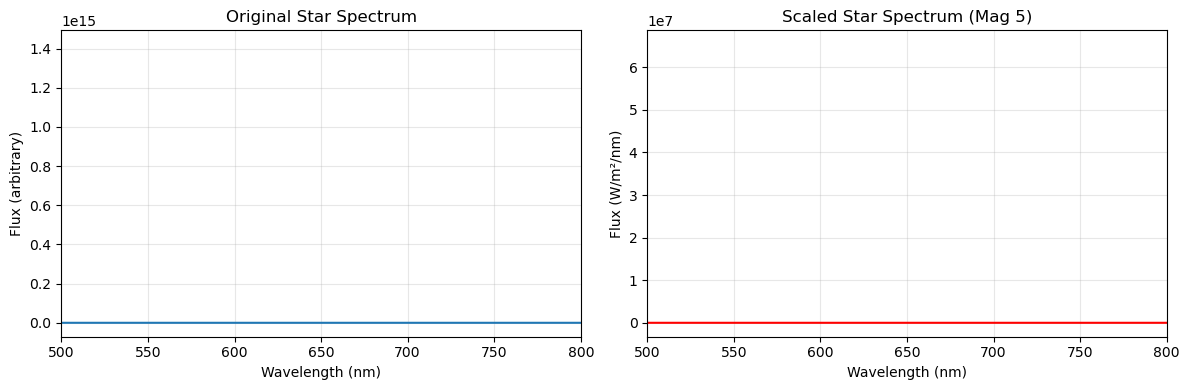


Scaling lamp spectrum to magnitude 8 using 500-700nm range...
Lamp spectrum scaled to mag 8, output shape: (601, 1)
Mean flux in 500-700nm: 2.30e-15 W/m²/nm
Expected flux for mag 8: 2.30e-15 W/m²/nm
Scaling accuracy: 0.0% error


In [ ]:
# Example usage with both star and lamp spectra
import matplotlib.pyplot as plt

# Scale star spectrum to magnitude 5 (using the fixed version)
if not star_spectra_df_fixed.empty:
    print("Scaling star spectrum to magnitude 5...")
    star_mag5 = scale_spectrum_to_magnitude(star_spectra_df_fixed, target_magnitude=5.0)
    print(f"Star spectrum scaled to mag 5, output shape: {star_mag5.shape}")
    
    # Plot comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Original spectrum (arbitrary units)
    ax1.plot(star_spectra_df_fixed.index, star_spectra_df_fixed.iloc[:, 0], label='Original (arbitrary units)')
    ax1.set_xlabel('Wavelength (nm)')
    ax1.set_ylabel('Flux (arbitrary)')
    ax1.set_title('Original Star Spectrum')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(500, 800)
    
    # Scaled spectrum (SI units)
    ax2.plot(star_mag5.index, star_mag5.iloc[:, 0], label='Magnitude 5', color='red')
    ax2.set_xlabel('Wavelength (nm)')
    ax2.set_ylabel('Flux (W/m²/nm)')
    ax2.set_title('Scaled Star Spectrum (Mag 5)')
    ax2.grid(True, alpha=0.3)
    ax2.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    ax2.set_xlim(500, 800)
    
    plt.tight_layout()
    plt.show()

# Scale lamp spectrum to magnitude 8 with different wavelength range
if not lamp_spectra_df.empty:
    print("\nScaling lamp spectrum to magnitude 8 using 500-700nm range...")
    lamp_mag8 = scale_spectrum_to_magnitude(
        lamp_spectra_df.iloc[:, [0]],  # Take first lamp spectrum
        target_magnitude=8.0,
        wavelength_range=(500, 700) * u.nm
    )
    print(f"Lamp spectrum scaled to mag 8, output shape: {lamp_mag8.shape}")
    
    # Show scaling in the reference range
    ref_mask = (lamp_mag8.index >= 500) & (lamp_mag8.index <= 700)
    mean_flux = lamp_mag8.loc[ref_mask].mean().iloc[0]
    expected_flux = (3.64e-9 * 10**(-0.4 * 8.0) * u.erg / u.cm**2 / u.s / u.nm).to(u.W / u.m**2 / u.nm).value
    
    print(f"Mean flux in 500-700nm: {mean_flux:.2e} W/m²/nm")
    print(f"Expected flux for mag 8: {expected_flux:.2e} W/m²/nm")
    print(f"Scaling accuracy: {abs(mean_flux - expected_flux) / expected_flux * 100:.1f}% error")